In [5]:
from pathlib import Path
import os
import sys


sys.path.append(str(Path(os.getcwd()).parents[0]))
from Helper_Functions import common_utils

directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "recursive_DBscan_paths", "recursive_dbscan_paths",0)

Extracting : 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


In [6]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
from sklearn.cluster import DBSCAN

In [ ]:
data = pd.read_csv("urbanGB.csv")
data.head()

,Lat,Lon
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


In [ ]:
len(data)

1000

In [ ]:
data.isna().sum()

Lat    0
Lon    0
dtype: int64

In [ ]:
data = data[10000:11000]
data.reset_index(drop=True)

,Lat,Lon
0,-0.241418,51.4935
1,-1.872240,52.5035
2,-4.129580,50.3899
3,-1.207950,51.7372
4,-1.504580,52.9292
...,...,...
995,-1.449420,53.8244
996,-2.138800,52.5680
997,-3.162600,51.7660
998,-2.287950,53.4612


In [ ]:
def plot(data,res):
  sns.set(rc={'figure.figsize':(20,15)})
  pl = sns.scatterplot(data = data,x=data["Lat"], y=data["Lon"],hue=res)
  pl.set_title("Cluster's Profile Based On Lat and Lon")
  plt.legend()
  plt.show()

In [ ]:
index =[]
cluster_to_row_mapping = {}
def recursive_dbscan(data, eps_min_radius, eps_max_radius, cluster_label=""):
  MIN_NUMBER_OF_CLUSTER = 2
  MAX_NODES_IN_CLUSTER = 200
  MAX_AVG_CLUSTER_SIZE = 0
  best_clusters = np.array([])
  cluster_names = np.array([])
  while eps_min_radius < eps_max_radius:
    eps_curr_radius = (eps_min_radius + eps_max_radius) / 2
    clusters = DBSCAN(eps=eps_curr_radius).fit(data)
    
    cluster_names = []
    for i in clusters.labels_:
      cluster_names.append(str(cluster_label)+str(i))
    clusters.labels_ =np.array(cluster_names)
    if len(np.unique(clusters.labels_)) < MIN_NUMBER_OF_CLUSTER: # not enough clusters
      eps_max_radius = eps_curr_radius - 0.01
    else:
      eps_min_radius = eps_curr_radius + 0.01
      av_cluster_size = len(clusters.labels_)/len(np.unique(clusters.labels_))
      if av_cluster_size > MAX_AVG_CLUSTER_SIZE: # choose the biggest cluster possible
        best_clusters = clusters.labels_
        MAX_AVG_CLUSTER_SIZE = av_cluster_size

  ## best_clusters is empty is only on cluster is formed even after reducing the curr_radius while min_radius < max_radius
  ## If this happens we will reduce the min_radius by half and call recursive_dbscan again till we get best_clusters
  if best_clusters.size == 0:
    print("Oh god why?")
    best_clusters = best_clusters[best_clusters != cluster_label]
    best_clusters = np.append(best_clusters, recursive_dbscan(data, eps_min_radius/2, 1.0, cluster_label))

  data['Cluster'] = best_clusters
  cluster_count_dict = dict(data['Cluster'].value_counts())
  
  ## cluster_to_row_mapping dictionary used to map clusters to row index
  for cluster in cluster_count_dict:
    for i in data.index[data['Cluster'] == cluster].tolist():
        cluster_to_row_mapping[i] = cluster
  
  for cluster in cluster_count_dict:
    if cluster_count_dict[cluster] > MAX_NODES_IN_CLUSTER:
      #print(f"Split cluster : {cluster}")
      new_data = data[data['Cluster'] == cluster].copy(deep=True)
      new_data.drop(columns=['Cluster'], inplace = True)
      best_clusters = best_clusters[best_clusters != cluster]
      best_clusters = np.append(best_clusters, recursive_dbscan(new_data, eps_min_radius/2, 1.0, cluster))
    
  return best_clusters

In [ ]:
resultant_clusters = recursive_dbscan(data, 0.1, 1.0)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [ ]:
data['Cluster'] = None

In [ ]:
for i in cluster_to_row_mapping:
  data.iloc[i-min(cluster_to_row_mapping.keys()), 2] = cluster_to_row_mapping[i]

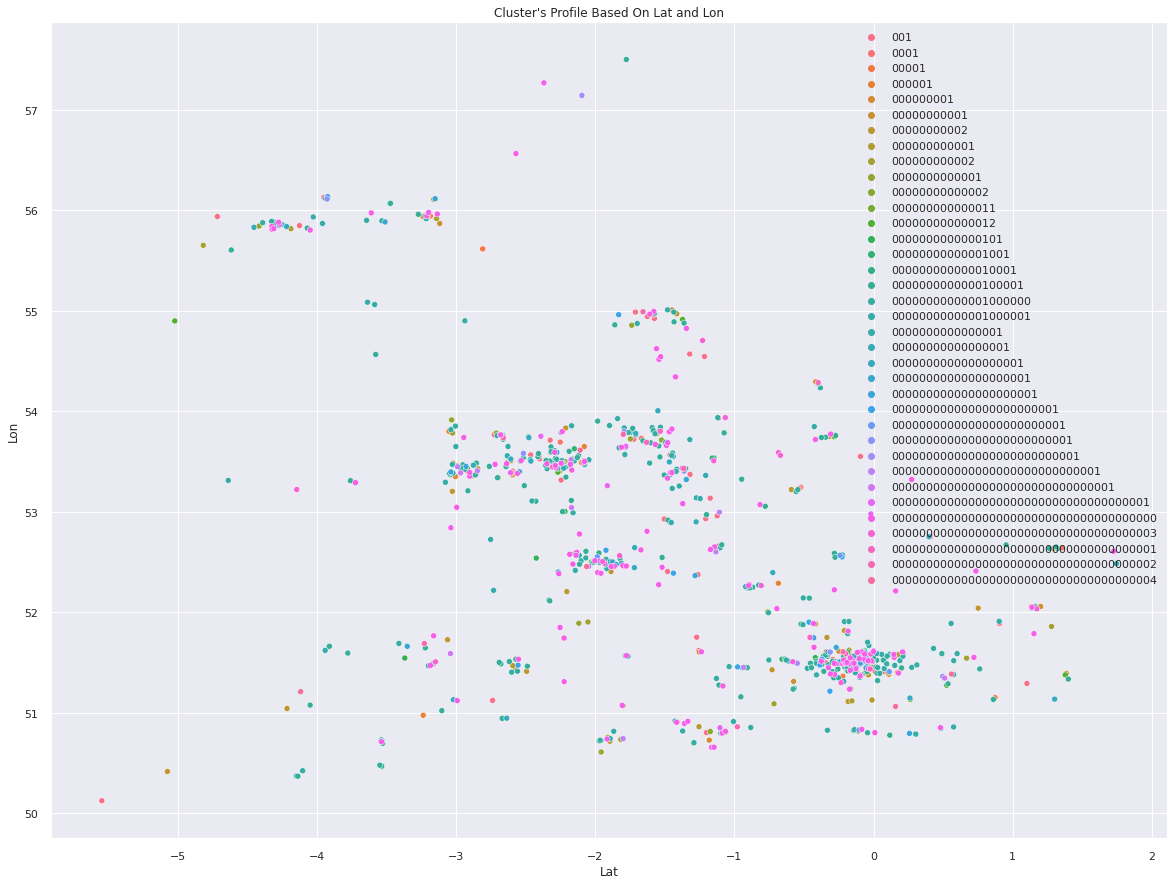

In [ ]:
plot(data, data['Cluster'])

In [ ]:
data.drop(data[data['Cluster'].str.contains('-1')].index, inplace = True) # Remove outliers

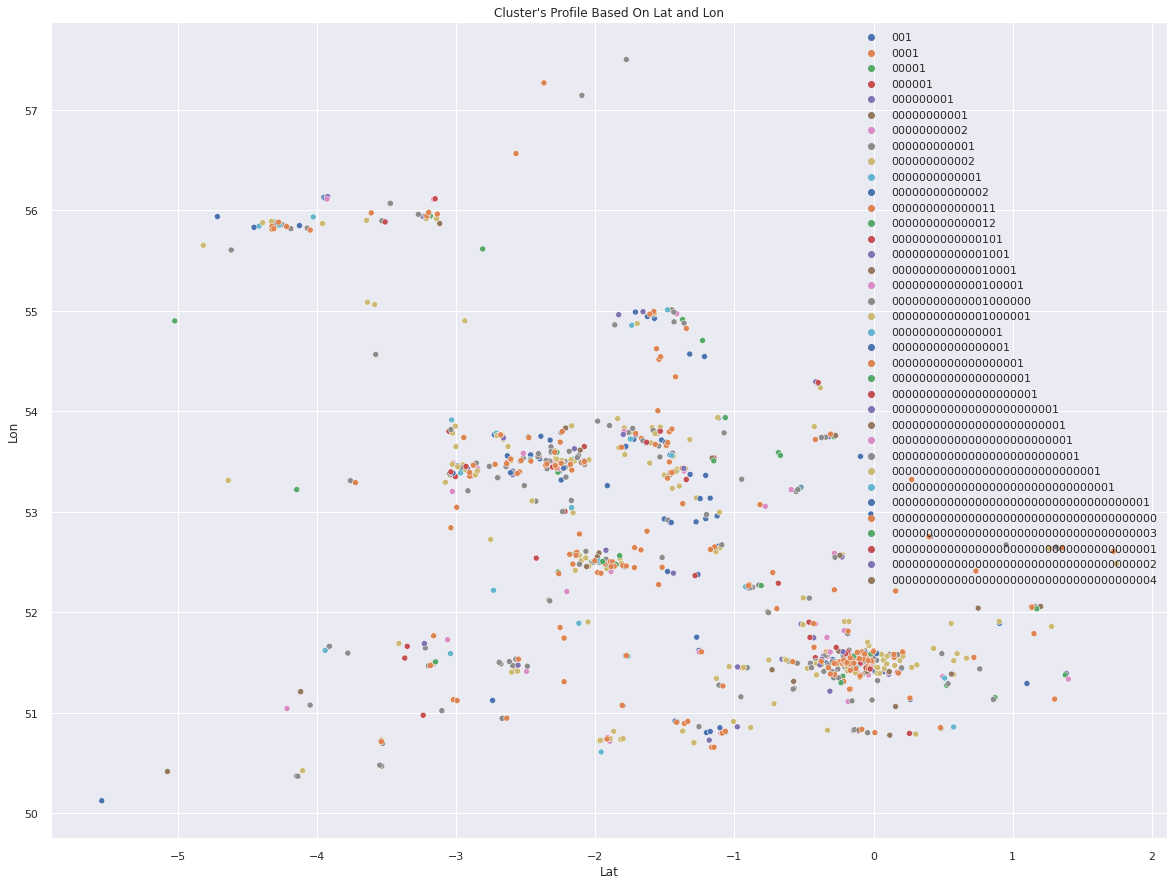

In [ ]:
plot(data, data['Cluster'])